In [33]:
import pickle
import os
from glob import glob

import numpy as np
import pandas as pd
import cv2
from matplotlib import pyplot as plt
import seaborn as sns

## Generate Tags

In [3]:
tags = {}

for filepath in glob('data/*.txt'):
    filename = os.path.basename(filepath).replace('.txt', '')
    classification = eval(filename.split('_')[0])
    
    img_name = filename.split('_')[1]
    tags[img_name] = classification

## Generate Metadata

In [13]:
meta = {}

for filepath in glob('data/*.pkl'):
    filename = os.path.basename(filepath).replace('.pkl', '')
    data = pickle.load(open(filepath, 'rb'))
    
    classification = True if filename.split('_')[0] == 'occupied' else False
    
    img_name = filename.split('_')[1]
    meta[img_name] = {}
    meta[img_name]['pred'] = classification
    meta[img_name]['actual'] = tags.get(img_name, False)
    meta[img_name]['pir_5'] = np.mean(data['pir'][-5:])
    meta[img_name]['pir_10'] = np.mean(data['pir'][-10:])
    meta[img_name]['pir_20'] = np.mean(data['pir'][-20:])
    meta[img_name]['pir_30'] = np.mean(data['pir'][-30:])
    meta[img_name]['pir_100'] = np.mean(data['pir'][-100:])
    

In [14]:
# meta

In [17]:
pd_data = {
    'img_name': [],
    'pred': [],
    'actual': [],
    'pir_5': [],
    'pir_10': [],
    'pir_20': [],
    'pir_30': [],
    'pir_100': []
}
for img_name, data in meta.items():
    pd_data['img_name'].append(img_name)
    for key, value in data.items():
        pd_data[key].append(value)

In [18]:
df = pd.DataFrame(pd_data)

In [19]:
print (df.shape)
df.head()

(1220, 8)


,img_name,pred,actual,pir_5,pir_10,pir_20,pir_30,pir_100
0,2018-10-30-17-02-08.106033,False,False,0.0,0.0,0.0,0.0,0.24
1,2018-10-30-10-58-39.388892,False,False,0.0,0.0,0.0,0.0,0.00
2,2018-10-30-08-48-29.191265,False,False,0.0,0.0,0.0,0.0,0.26
3,2018-10-30-20-25-55.820775,True,True,0.0,0.0,0.0,0.0,0.00
4,2018-10-29-19-28-07.691267,False,False,0.0,0.0,0.0,0.0,0.00


In [20]:
df.groupby(['pred', 'actual']).pir_10.agg({'mean': 'mean', 'cnt': 'count'}).reset_index()

/Users/ianwhitestone/miniconda3/envs/rpi/lib/python3.6/site-packages/ipykernel/__main__.py:1: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


,pred,actual,mean,cnt
0,False,False,0.048791,1158
1,True,False,0.342308,26
2,True,True,0.444444,36


In [23]:
df.groupby(['pred', 'actual']).pir_20.agg({'mean': 'mean', 'cnt': 'count'}).reset_index()

/Users/ianwhitestone/miniconda3/envs/rpi/lib/python3.6/site-packages/ipykernel/__main__.py:1: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


,pred,actual,mean,cnt
0,False,False,0.054706,1158
1,True,False,0.288462,26
2,True,True,0.386111,36


In [45]:
df.to_csv('data.csv', index=False)

## Inspecting Some Files

In [24]:
tp_pkl_file = open('tp_example.pkl', 'rb')
fp_pkl_file = open('fp_example.pkl', 'rb')
oth_pkl_file = open('data/occupied_2018-11-02-23-08-31.498366.pkl', 'rb')

tp_data = pickle.load(tp_pkl_file)
fp_data = pickle.load(fp_pkl_file)
oth_data = pickle.load(oth_pkl_file)

In [14]:
print (np.mean(tp_data['pir']))
print (np.mean(tp_data['pir'][-10:]))

0.04
1.0


In [15]:
print (np.mean(fp_data['pir']))
print (np.mean(fp_data['pir'][-10:]))

0.0
0.0


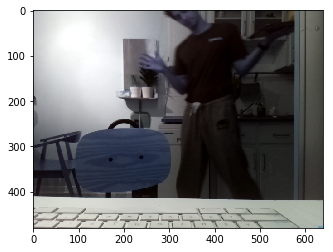

In [23]:
plt.imshow(tp_data['frame'])

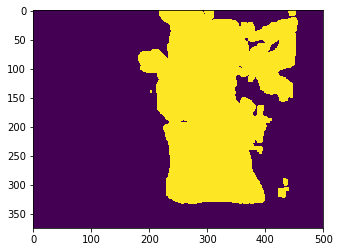

In [25]:
plt.imshow(tp_data['frame_delta'])

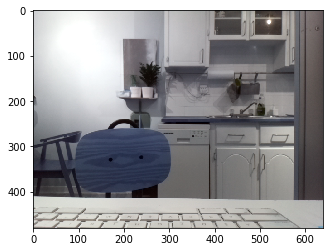

In [26]:
plt.imshow(fp_data['frame'])

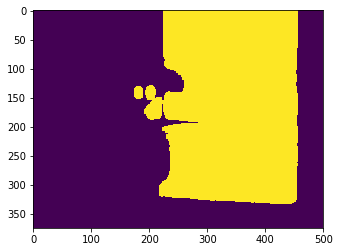

In [27]:
plt.imshow(fp_data['frame_delta'])

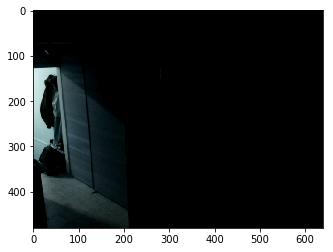

In [25]:
plt.imshow(oth_data['frame'])

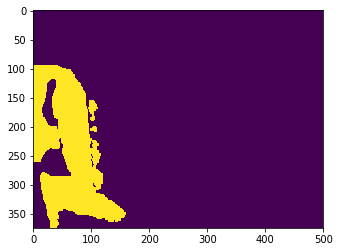

In [26]:
plt.imshow(oth_data['frame_delta'])

In [31]:
cv2.imwrite('oth.jpg', oth_data['frame'])

True